In [1]:
# Load in needed libraries and code

import os
import json
import numpy as np
import torch as th
import motornet as mn
import pickle
import matplotlib.pyplot as plt

from my_policy import Policy  # the RNN
from my_task import CentreOutFF  # the task
from my_loss import cal_loss  # the loss function
from my_utils import (
    save_model,
    print_losses,
    plot_stuff,
    run_episode,
    test,
    plot_training_log,
    plot_simulations,
    plot_activation,
    plot_kinematics,
)  # utility functions
print("All packages imported.")
print("pytorch version: " + th.__version__)
print("numpy version: " + np.__version__)
print("motornet version: " + mn.__version__)

All packages imported.
pytorch version: 2.8.0
numpy version: 2.2.6
motornet version: 0.2.0


In [3]:
# load up one of the trained models

loss_weights = [1e+3, 2e+2, 1e+6, 1e+0, 0, 1e-1, 1e+4] # michaels 2025 nature paper

model_dir  = "models_kashefi"
model_name = "m1"
data = test(
        model_dir + "/" + model_name + "/" + "cfg.json",
        model_dir + "/" + model_name + "/" + "weights",
        ff_coefficient=0,
        loss_weights=loss_weights
    )[0]
print(data.keys())

dict_keys(['xy', 'obs', 'tg', 'vel', 'all_actions', 'all_hidden', 'all_muscle', 'all_force'])


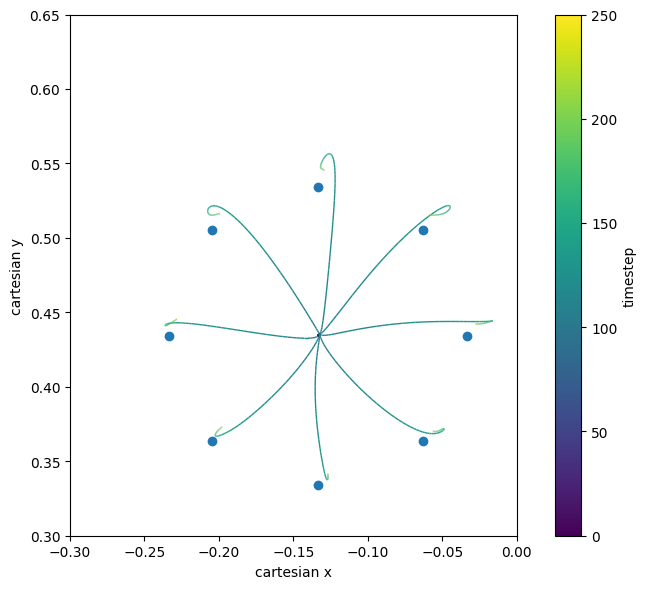

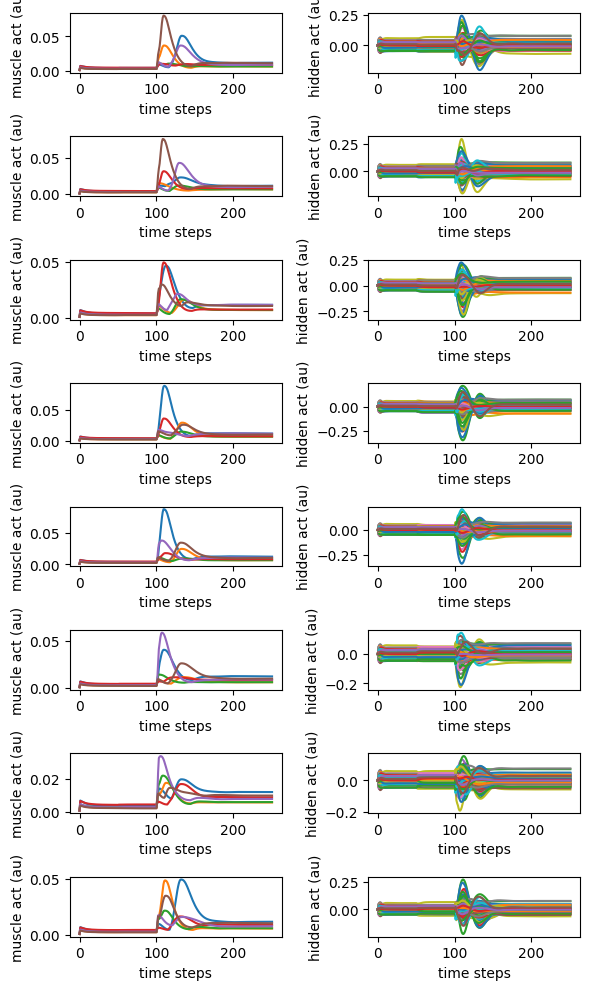

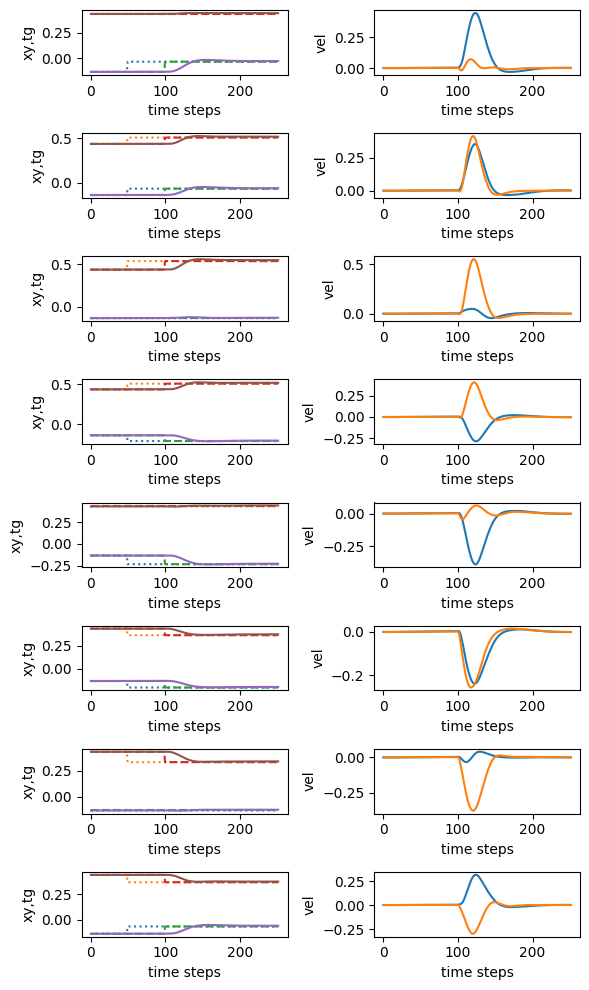

In [4]:
# generate some plots of hand paths, muscle activations & network activity, and joint kinematics

fig, ax = plot_simulations(xy=data["xy"], target_xy=data["tg"], figsize=(8, 6))
fig, ax = plot_activation(data["all_hidden"], data["all_muscle"])
fig, ax = plot_kinematics(all_xy=data["xy"], all_tg=data["tg"], all_vel=data["vel"], all_obs=data["obs"])

torch.Size([251, 8])


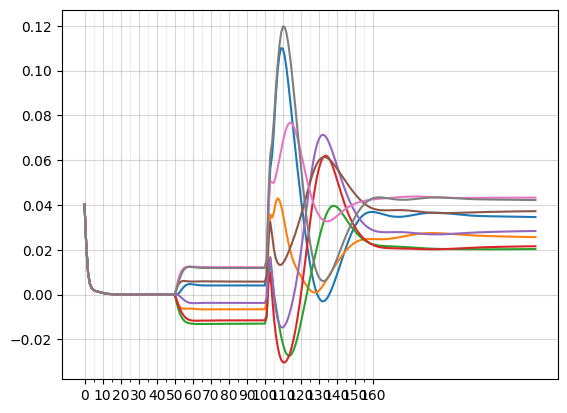

In [28]:
# plot hidden unit activity of one unit for the 8 center-out targets

h = data["all_hidden"][:,:,0].T # [tgt,time,neuron]
print(np.shape(h))
n_time = np.shape(h)[0]
time = np.arange(0,n_time,1)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time,h)
major_ticks = np.arange(0, 161, 10)
minor_ticks = np.arange(0, 161, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()

/var/folders/xc/_p3tnrwj5fv7spj_9b5jw6sm0000gn/T/ipykernel_48948/3262457261.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hh = h - np.tile(h0,[n_time,1])


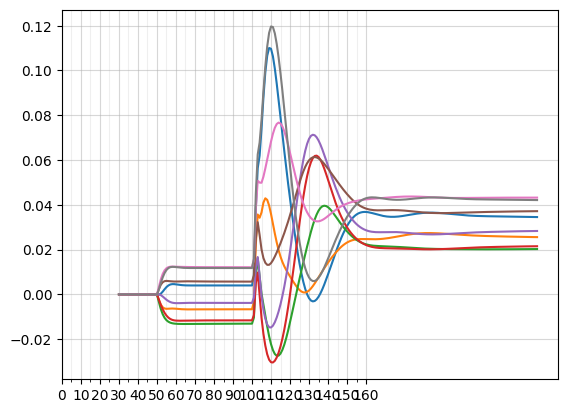

In [29]:
# chop off some of the initial drifting activity that starts at time zero

n_tgt = int(0.500/0.01) # target shifts at t=0.500 s
n_win = int(0.200/0.01) # 200 ms window prior to target shift
h0 = th.mean(h[n_tgt-n_win:n_tgt,:], axis=0) # mean hidden activity over n_win timesteps up to tgt shift
hh = h - np.tile(h0,[n_time,1])
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time[n_tgt-n_win:], hh[n_tgt-n_win:])
major_ticks = np.arange(0, 161, 10)
minor_ticks = np.arange(0, 161, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()

In [15]:
# import the dPCA library so we can use it to analyse the population of hidden unit activity

from dPCA.dPCA import dPCA

In [36]:
# organize the data into handpaths, targets, and hidden unit activity

xy = data['xy'].detach().numpy()
tg = data['tg'].detach().numpy()
hid = data['all_hidden'].detach().numpy()

n_tgt, n_time, n_neuron = hid.shape
print(f"xy: {np.shape(xy)}")
print(f"tg: {np.shape(tg)}")
print(f"hid: {np.shape(hid)}")
print(f"hidden activity shape: {n_tgt} tgts, {n_time} time points, {n_neuron} neurons")


xy: (8, 251, 2)
tg: (8, 251, 2)
hid: (8, 251, 256)
hidden activity shape: 8 tgts, 251 time points, 256 neurons


In [37]:
# zero hidden activity to just prior to the tgt cue
go_cue = int(0.500/0.01) # time step of tgt cue
for n in range(n_neuron):
    for t in range(n_tgt):
        hid[t,:,n] = hid[t,:,n] - hid[t,go_cue-1,n]

# chop off activity prior to the tgt cue, keep 200 before
hid = hid[:, go_cue-int(0.200/.01):, :]
n_tgt, n_time, n_neuron = hid.shape
print(f"hidden activity shape: {n_tgt} tgts, {n_time} time points, {n_neuron} neurons")

hidden activity shape: 8 tgts, 221 time points, 256 neurons


In [38]:
# compute the angle of each of the 8 targets from the movement origin (center target)

yy = tg[:, -1, 1] - xy[:, 0, 1]
xx = tg[:, -1, 0] - xy[:, 0, 0]
angles = np.mod(np.arctan2(yy, xx) + 2*np.pi, 2*np.pi)
print(f"tgt angles: {np.round(angles*180/np.pi)} degrees")

tgt angles: [  0.  45.  90. 135. 180. 225. 270. 315.] degrees


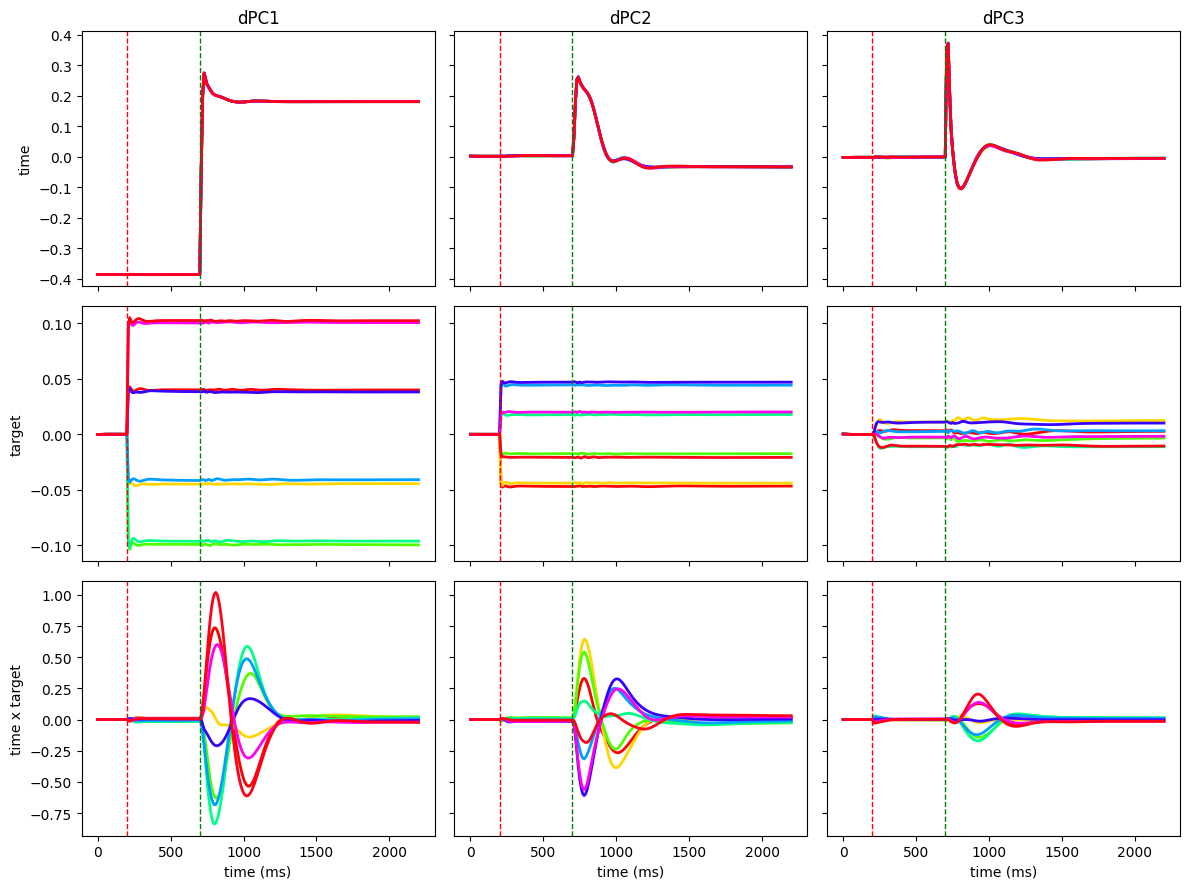

In [40]:
# perform a dPCA on the hidden unit activity
# using time points and target angles as labels

n_components = 3 # extract 3 dPCs
dpca = dPCA(labels='ta', n_components=n_components)
hid2 = hid.transpose(2,1,0)
hid_new = dpca.fit_transform(hid2)

legend = {k: k for k in hid_new.keys()}
legend['t'] = "time"
legend['a'] = "target"
legend['ta'] = "time x target"
dt = 10 # ms
tgtcue = 200 # ms
gocue  = 700 # ms
x = np.arange(0, n_time * dt, step=dt)
cm = plt.cm.hsv(np.linspace(0, 1, n_tgt))

fig, axs = plt.subplots(len(hid_new), n_components, sharey='row', sharex='col')
fig.set_tight_layout(True)
fig.set_size_inches((4 * n_components, 3 * len(hid_new)))

for i, (k, v) in enumerate(hid_new.items()):
  for j in range(n_components):
    axs[i, j].set_prop_cycle('color', list(cm))
    axs[i, j].plot(x, v[j, :, :], linewidth=2)
    axs[i, j].axvline(tgtcue, c='red', linewidth=1, linestyle='--')
    axs[i, j].axvline(gocue, c='green', linewidth=1, linestyle='--')

    if i == 0:
      axs[i, j].set_title("dPC" + str(j+1))
    if j == 0:
      axs[i, j].set_ylabel(legend[k])
    if i == len(legend)-1:
      axs[i, j].set_xlabel("time (ms)")

plt.show()


In [41]:
for (k,v) in hid_new.items():
    print(f"{k}: {np.shape(v)}")

t: (3, 221, 8)
a: (3, 221, 8)
ta: (3, 221, 8)


h_tg: (3, 221, 8)
h_go: (3, 221, 8)


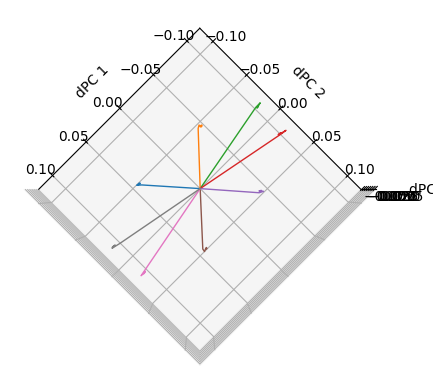

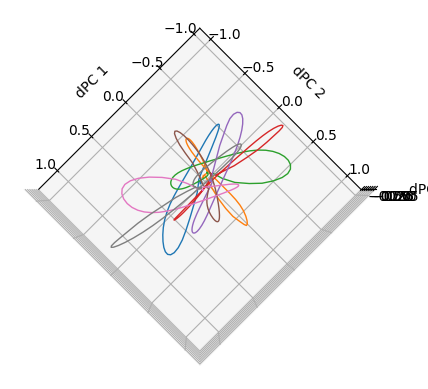

In [85]:
h_tg = hid_new['a']
print(f"h_tg: {np.shape(h_tg)}")
h_go = hid_new['ta']
print(f"h_go: {np.shape(h_go)}")
ax = plt.figure().add_subplot(projection='3d')
for i_tgt in range(n_tgt):
    ax.plot(h_tg[0,:69,i_tgt].T, h_tg[1,:69,i_tgt].T, 0, lw=1.0)
ax.set_xlabel("dPC 1")
ax.set_ylabel("dPC 2")
ax.set_zlabel("dPC 3")
ax.view_init(elev=90., azim=45, roll=0)
ax.axis('equal')
plt.show()

ax = plt.figure().add_subplot(projection='3d')
for i_tgt in range(n_tgt):
    ax.plot(h_tg[0,-1,i_tgt].T + h_go[0,70:,i_tgt].T, h_tg[1,-1,i_tgt].T + h_go[1,70:,i_tgt].T, 0, lw=1.0)
ax.set_xlabel("dPC 1")
ax.set_ylabel("dPC 2")
ax.set_zlabel("dPC 3")
ax.view_init(elev=90., azim=45, roll=0)
ax.axis('equal')
plt.show()


In [91]:
import plotly.graph_objects as go
import plotly.express as px

x = h_tg[0,:69,:]
y = h_tg[1,:69,:]
z = h_tg[2,:69,:]
x2 = h_go[0,70:,:] + h_tg[0,-1,:]
y2 = h_go[1,70:,:] + h_tg[1,-1,:]
z2 = h_go[2,70:,:] + h_tg[2,-1,:]

colors = px.colors.qualitative.Set1  # has 9 colors, so enough for 8

for i in range(x.shape[1]):
    color = colors[i % len(colors)]

    # Primary trajectory (thick line)
    fig.add_trace(go.Scatter3d(
        x=x[:, i], y=y[:, i], z=z[:, i],
        mode='lines',
        line=dict(color=color, width=6),   # thick line
        name=f"Target {i+1} A"
    ))

    # Secondary trajectory (thinner line, same color)
    fig.add_trace(go.Scatter3d(
        x=x2[:, i], y=y2[:, i], z=z2[:, i],
        mode='lines',
        line=dict(color=color, width=2),   # thinner line
        name=f"Target {i+1} B",
        showlegend=False   # hide duplicate legend entry
    ))

# Equal axis scaling
xmin, xmax = np.min([x.min(), x2.min()]), np.max([x.max(), x2.max()])
ymin, ymax = np.min([y.min(), y2.min()]), np.max([y.max(), y2.max()])
zmin, zmax = np.min([z.min(), z2.min()]), np.max([z.max(), z2.max()])

max_range = max(xmax - xmin, ymax - ymin, zmax - zmin)
x_mid = (xmax + xmin) / 2
y_mid = (ymax + ymin) / 2
z_mid = (zmax + zmin) / 2

fig.update_layout(
    width=800,   # make equal
    height=800,  # same as width → square
    scene=dict(
        xaxis=dict(range=[x_mid - max_range/2, x_mid + max_range/2]),
        yaxis=dict(range=[y_mid - max_range/2, y_mid + max_range/2]),
        zaxis=dict(range=[z_mid - max_range/2, z_mid + max_range/2]),
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, b=0, t=30),
    title="3D trajectories (8 targets, paired colors)"
)

fig.show()






In [92]:
x3 = np.concatenate([x, x2], axis=0)
y3 = np.concatenate([y, y2], axis=0)
z3 = np.concatenate([z, z2], axis=0)

T, n_targets = x3.shape

# --- Colors (8 distinct) ---
colors = px.colors.qualitative.Set1  # try 'Plotly', 'Dark2', 'Set2', etc.

# --- Equal-axis bounds computed once ---
xmin, xmax = x3.min(), x3.max()
ymin, ymax = y3.min(), y3.max()
zmin, zmax = z3.min(), z3.max()
max_range = max(xmax - xmin, ymax - ymin, zmax - zmin)
x_mid = (xmax + xmin) / 2
y_mid = (ymax + ymin) / 2
z_mid = (zmax + zmin) / 2
x_range = [x_mid - max_range/2, x_mid + max_range/2]
y_range = [y_mid - max_range/2, y_mid + max_range/2]
z_range = [z_mid - max_range/2, z_mid + max_range/2]

fig = go.Figure()

# --- Initial traces at t=0: for each target add (trail line, head marker) ---
for i in range(n_targets):
    color = colors[i % len(colors)]
    # Trail (thick line)
    fig.add_trace(go.Scatter3d(
        x=x3[:1, i], y=y3[:1, i], z=z3[:1, i],
        mode='lines',
        line=dict(color=color, width=6),
        name=f"Target {i+1}"
    ))
    # Head (marker)
    fig.add_trace(go.Scatter3d(
        x=[x3[0, i]], y=[y3[0, i]], z=[z3[0, i]],
        mode='markers',
        marker=dict(size=4, color=color),
        showlegend=False
    ))

# --- Frames: must match the number & order of traces above (2 per target) ---
frames = []
for k in range(T):
    frame_data = []
    for i in range(n_targets):
        # Trail up to time k
        frame_data.append(dict(
            type='scatter3d',
            x=x3[:k+1, i], y=y3[:k+1, i], z=z3[:k+1, i],
            mode='lines'
        ))
        # Head at time k
        frame_data.append(dict(
            type='scatter3d',
            x=[x3[k, i]], y=[y3[k, i]], z=[z3[k, i]],
            mode='markers'
        ))
    frames.append(go.Frame(data=frame_data, name=str(k)))

fig.frames = frames

# --- Slider & Play/Pause buttons ---
frame_ms = 40  # decrease for faster animation
sliders = [dict(
    steps=[dict(method="animate",
                args=[[str(k)],
                      dict(mode="immediate",
                           frame=dict(duration=frame_ms, redraw=True),
                           transition=dict(duration=0))],
                label=str(k)) for k in range(T)],
    x=0, y=0, len=1.0,
    transition=dict(duration=0),
    currentvalue=dict(prefix="t: ", visible=True)
)]

fig.update_layout(
    width=800,   # make equal
    height=800,  # same as width → square
    scene=dict(
        xaxis=dict(range=x_range, title='x3'),
        yaxis=dict(range=y_range, title='y3'),
        zaxis=dict(range=z_range, title='z3'),
        aspectmode='cube'
    ),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        x=0.02, y=1.12,
        buttons=[
            dict(label="▶ Play",
                 method="animate",
                 args=[None, dict(fromcurrent=True,
                                  frame=dict(duration=frame_ms, redraw=True),
                                  transition=dict(duration=0),
                                  mode="immediate")]),
            dict(label="⏸ Pause",
                 method="animate",
                 args=[[None], dict(frame=dict(duration=0, redraw=False),
                                    transition=dict(duration=0),
                                    mode="immediate")])
        ]
    )],
    sliders=sliders,
    margin=dict(l=0, r=0, b=0, t=30),
    title="Animated 3D trajectories of x3,y3,z3 (8 targets)"
)

fig.show()

# Optional: save as a standalone HTML you can open/share
# fig.write_html("x2y3z3_animation.html", include_plotlyjs='cdn', auto_play=True)
